# 🧪 Evaluation & Analysis

Интерактивный ноутбук для тестирования модели и анализа результатов

**Содержание:**
1. Загрузка модели
2. Тестирование на отдельных изображениях
3. Расчёт площади застройки
4. Визуализация результатов
5. Оценка на test set
6. Анализ метрик

In [2]:
import sys
sys.path.append('../src')

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import yaml
import json
from tqdm.notebook import tqdm

from model import create_model
from inference import load_model_from_checkpoint, predict_large_image, predict_from_file
from area_calculator import AreaCalculator
from visualize import (
    visualize_prediction,
    visualize_overlay,
    visualize_comparison,
    plot_metrics_comparison
)
from metrics import SegmentationMetrics, calculate_metrics

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

## 1. Настройки

In [3]:
# Пути
CONFIG_PATH = '../configs/config.yaml'
CHECKPOINT_PATH = '../models/checkpoints/best_model.pth'
DATA_ROOT = '../data/AerialImageDataset'

# Устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Устройство: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Устройство: cuda
GPU: NVIDIA GeForce RTX 5070


## 2. Загрузка конфигурации

In [4]:
# Загружаем конфиг
with open(CONFIG_PATH, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

print("Конфигурация модели:")
print(f"  Архитектура: {config['model']['name']}")
print(f"  Encoder: {config['model']['encoder_name']}")
print(f"  Patch size: {config['dataset']['patch_size']}")

Конфигурация модели:
  Архитектура: unet
  Encoder: resnet50
  Patch size: 512


## 3. Загрузка модели

In [5]:
# Создаём модель
print("Создание модели...")
model = create_model(config['model'], device)

# Загружаем веса
print(f"\nЗагрузка checkpoint: {CHECKPOINT_PATH}")
model = load_model_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    model=model,
    device=device
)

print("\n✓ Модель готова к inference!")

Создание модели...
Создана модель unet с энкодером resnet50
Загружены pretrained веса: imagenet

Параметры модели:
  Всего: 32,521,105
  Обучаемых: 32,521,105
  Замороженных: 0
  Устройство: cuda

Загрузка checkpoint: ../models/checkpoints/best_model.pth
Загрузка checkpoint: ../models/checkpoints/best_model.pth
✓ Checkpoint загружен:
  Эпоха: 32
  Best metric: 0.7725

✓ Модель готова к inference!


## 4. Тест на одном изображении

Выберите изображение из test set для демонстрации

In [6]:
# Список доступных test изображений
test_images_dir = Path(DATA_ROOT) / 'test' / 'images'
test_images = sorted(list(test_images_dir.glob('*.tif')))

print(f"Доступно тестовых изображений: {len(test_images)}")
print("\nПервые 10 файлов:")
for i, img_path in enumerate(test_images[:10]):
    print(f"  {i+1}. {img_path.name}")

Доступно тестовых изображений: 180

Первые 10 файлов:
  1. bellingham1.tif
  2. bellingham10.tif
  3. bellingham11.tif
  4. bellingham12.tif
  5. bellingham13.tif
  6. bellingham14.tif
  7. bellingham15.tif
  8. bellingham16.tif
  9. bellingham17.tif
  10. bellingham18.tif


In [7]:
# Выберите изображение (измените индекс)
test_image_idx = 0
test_image_path = str(test_images[test_image_idx])

print(f"Выбрано изображение: {Path(test_image_path).name}")

# Загружаем изображение
image = np.array(Image.open(test_image_path).convert('RGB'))
print(f"Размер изображения: {image.shape}")

Выбрано изображение: bellingham1.tif
Размер изображения: (5000, 5000, 3)


### 4.1 Запуск inference

In [8]:
# Предсказание
print("Запуск inference...")
pred_mask, pred_probs = predict_large_image(
    model=model,
    image=image,
    device=device,
    patch_size=config['dataset']['patch_size'],
    stride=config['dataset']['test_stride'],
    use_amp=True,
    threshold=0.5
)

print(f"\nПредсказание выполнено!")
print(f"Pred mask shape: {pred_mask.shape}")
print(f"Pred probs range: [{pred_probs.min():.3f}, {pred_probs.max():.3f}]")

Запуск inference...


Processing patches: 100%|██████████| 100/100 [00:02<00:00, 41.67it/s]



Предсказание выполнено!
Pred mask shape: (5000, 5000)
Pred probs range: [0.000, 0.999]


### 4.2 Расчёт площади

In [9]:
# Создаём калькулятор
calculator = AreaCalculator(pixel_size_m=0.3)

# Расчёт площади
areas = calculator.calculate_area(pred_mask)

print("="*80)
print("РАСЧЁТ ПЛОЩАДИ ЗАСТРОЙКИ")
print("="*80)
print(f"Площадь застройки: {calculator.format_area(areas['area_m2'])}")
print(f"  В м²: {areas['area_m2']:.2f}")
print(f"  В га: {areas['area_ha']:.2f}")
print(f"Количество пикселей зданий: {areas['building_pixels']:,}")
print(f"Покрытие: {areas['coverage_percent']:.2f}%")
print("="*80)

РАСЧЁТ ПЛОЩАДИ ЗАСТРОЙКИ
Площадь застройки: 16.15 га
  В м²: 161522.55
  В га: 16.15
Количество пикселей зданий: 1,794,695
Покрытие: 7.18%


### 4.3 Визуализация

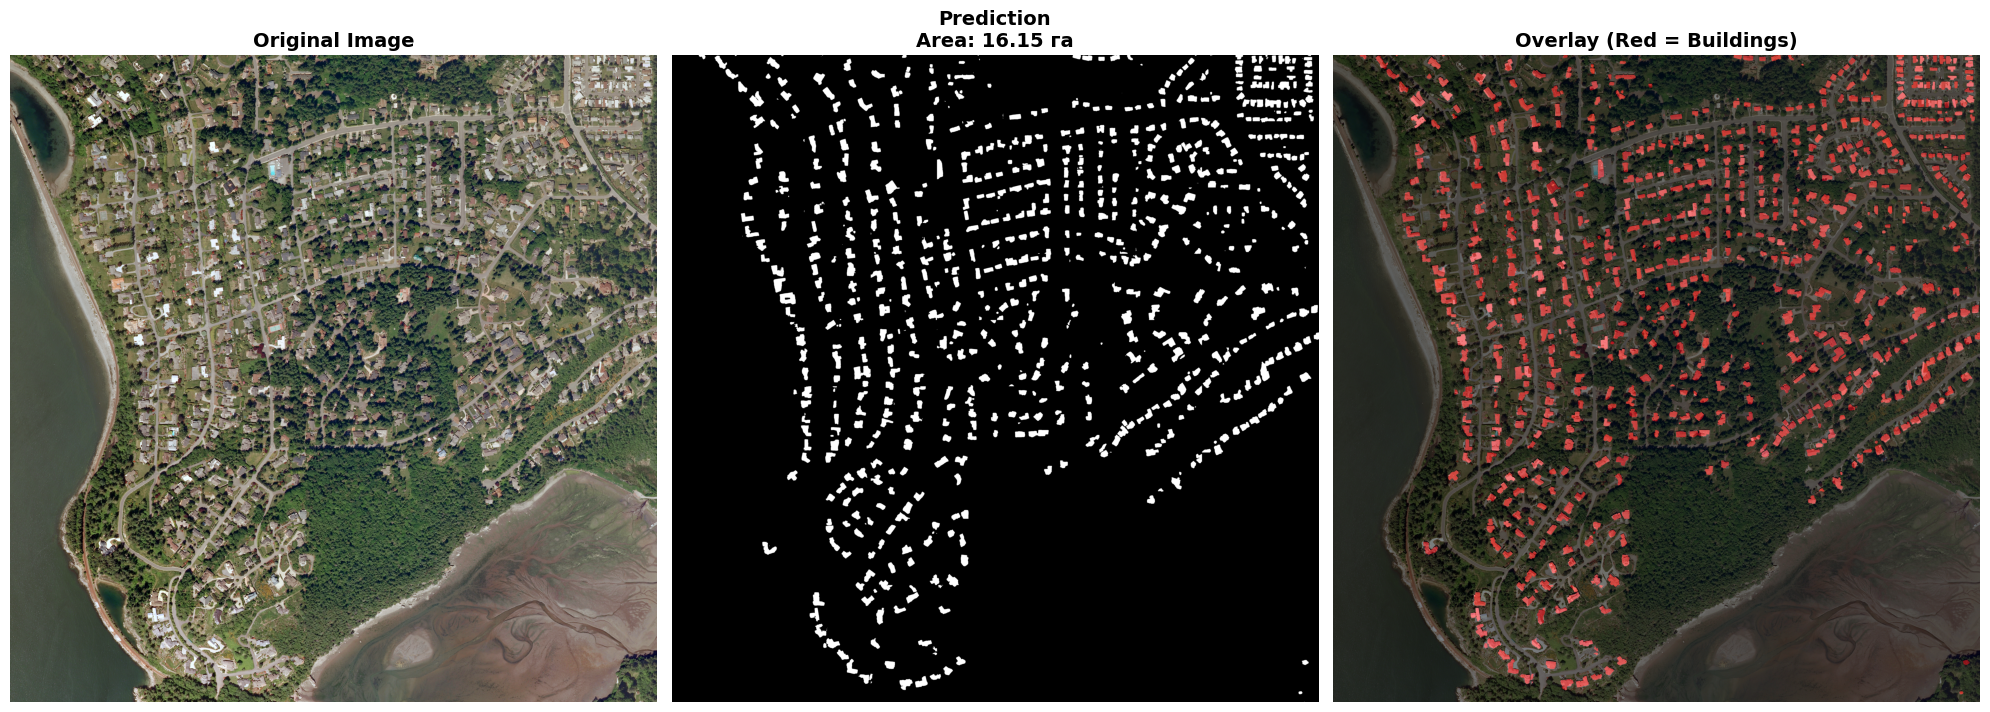

In [10]:
# Простая визуализация
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Original
axes[0].imshow(image)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Prediction
axes[1].imshow(pred_mask, cmap='gray')
axes[1].set_title(f'Prediction\nArea: {areas["area_ha"]:.2f} га', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Overlay
axes[2].imshow(image)
overlay = np.zeros_like(image)
overlay[pred_mask > 0] = [255, 0, 0]
axes[2].imshow(overlay, alpha=0.5)
axes[2].set_title('Overlay (Red = Buildings)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

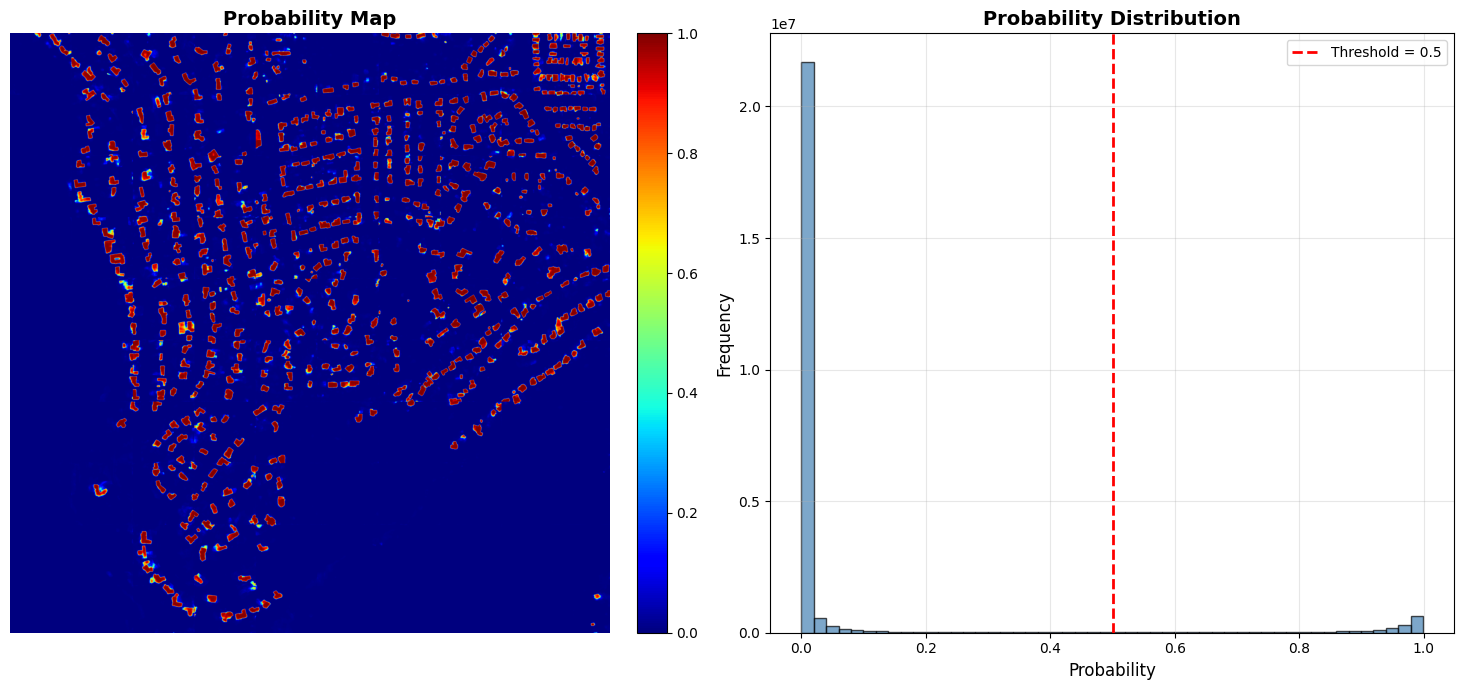

In [11]:
# Карта вероятностей
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Probability map
im = axes[0].imshow(pred_probs, cmap='jet', vmin=0, vmax=1)
axes[0].set_title('Probability Map', fontsize=14, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

# Histogram
axes[1].hist(pred_probs.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
axes[1].set_xlabel('Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Probability Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Тест с Ground Truth (для train set)

Для сравнения с GT нужно использовать изображения из train set

In [12]:
# Берём изображение из train set
train_images_dir = Path(DATA_ROOT) / 'train' / 'images'
train_gt_dir = Path(DATA_ROOT) / 'train' / 'gt'

train_images = sorted(list(train_images_dir.glob('*.tif')))
print(f"Доступно train изображений: {len(train_images)}")

# Выбираем первое
train_image_path = train_images[0]
train_gt_path = train_gt_dir / train_image_path.name

print(f"Выбрано: {train_image_path.name}")

Доступно train изображений: 180
Выбрано: austin1.tif


In [13]:
# Загружаем изображение и GT
train_image = np.array(Image.open(train_image_path).convert('RGB'))
train_gt = np.array(Image.open(train_gt_path)) > 0  # Бинаризация

print(f"Image shape: {train_image.shape}")
print(f"GT shape: {train_gt.shape}")
print(f"GT values: {np.unique(train_gt)}")

Image shape: (5000, 5000, 3)
GT shape: (5000, 5000)
GT values: [False  True]


In [14]:
# Предсказание
print("Запуск inference...")
train_pred_mask, train_pred_probs = predict_large_image(
    model=model,
    image=train_image,
    device=device,
    patch_size=512,
    stride=512,
    use_amp=True,
    threshold=0.5
)
print("✓ Готово!")

Запуск inference...


Processing patches: 100%|██████████| 100/100 [00:01<00:00, 50.53it/s]


✓ Готово!


### 5.1 Расчёт метрик

In [15]:
# Конвертируем в torch для метрик
train_pred_tensor = torch.from_numpy(train_pred_probs).unsqueeze(0).unsqueeze(0)
train_gt_tensor = torch.from_numpy(train_gt.astype(np.uint8)).unsqueeze(0)

# Вычисляем метрики
metrics = calculate_metrics(train_pred_tensor, train_gt_tensor)

print("="*80)
print("МЕТРИКИ")
print("="*80)
for name, value in metrics.items():
    print(f"{name:12s}: {value:.4f}")
print("="*80)

МЕТРИКИ
iou         : 0.7899
dice        : 0.8826
f1          : 0.8826
accuracy    : 0.9656
precision   : 0.8900
recall      : 0.8753
specificity : 0.9813


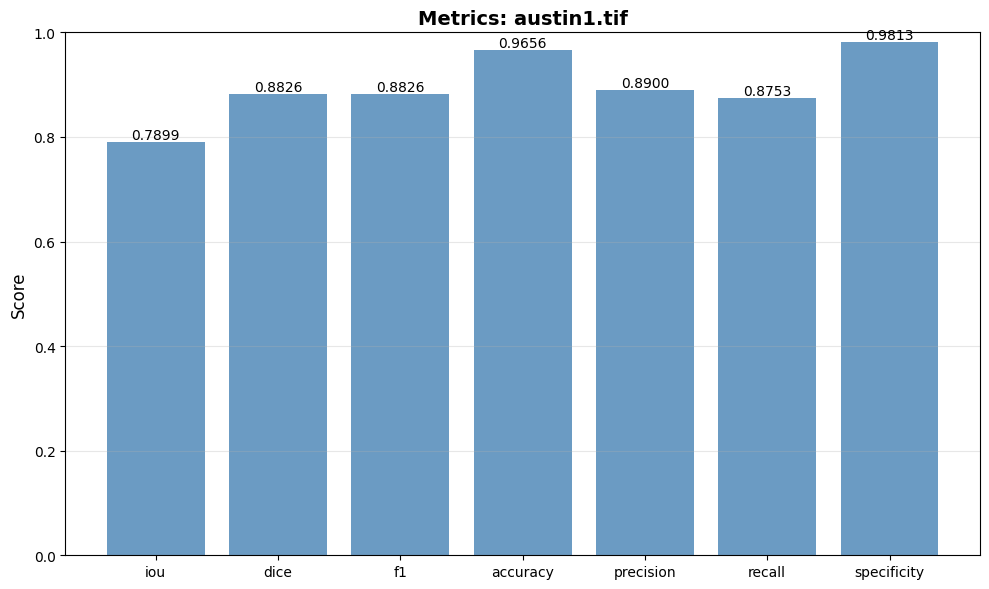

In [16]:
# Визуализация метрик
plot_metrics_comparison(
    metrics=metrics,
    title=f"Metrics: {train_image_path.name}"
)

### 5.2 Расчёт площади с GT

In [17]:
# Расчёт площади с детализацией
areas_detailed = calculator.calculate_per_class_area(
    pred_mask=train_pred_mask,
    gt_mask=train_gt.astype(np.uint8)
)

# Красивый вывод
calculator.print_summary(areas_detailed)


РАСЧЁТ ПЛОЩАДИ ЗАСТРОЙКИ

ПРЕДСКАЗАНО:
  Площадь застройки: 32.65 га
  Количество пикселей: 3,627,793
  Покрытие: 14.51%

GROUND TRUTH:
  Площадь застройки: 33.20 га
  Количество пикселей: 3,688,758
  Покрытие: 14.76%

РАЗНИЦА:
  Абсолютная: 5486.85 м²
  Относительная: -1.65%

ДЕТАЛИЗАЦИЯ:
  True Positive:  29.06 га (12.92%)
  False Positive: 3.59 га (1.60%)
  False Negative: 4.14 га (1.84%)



### 5.3 Детальное сравнение

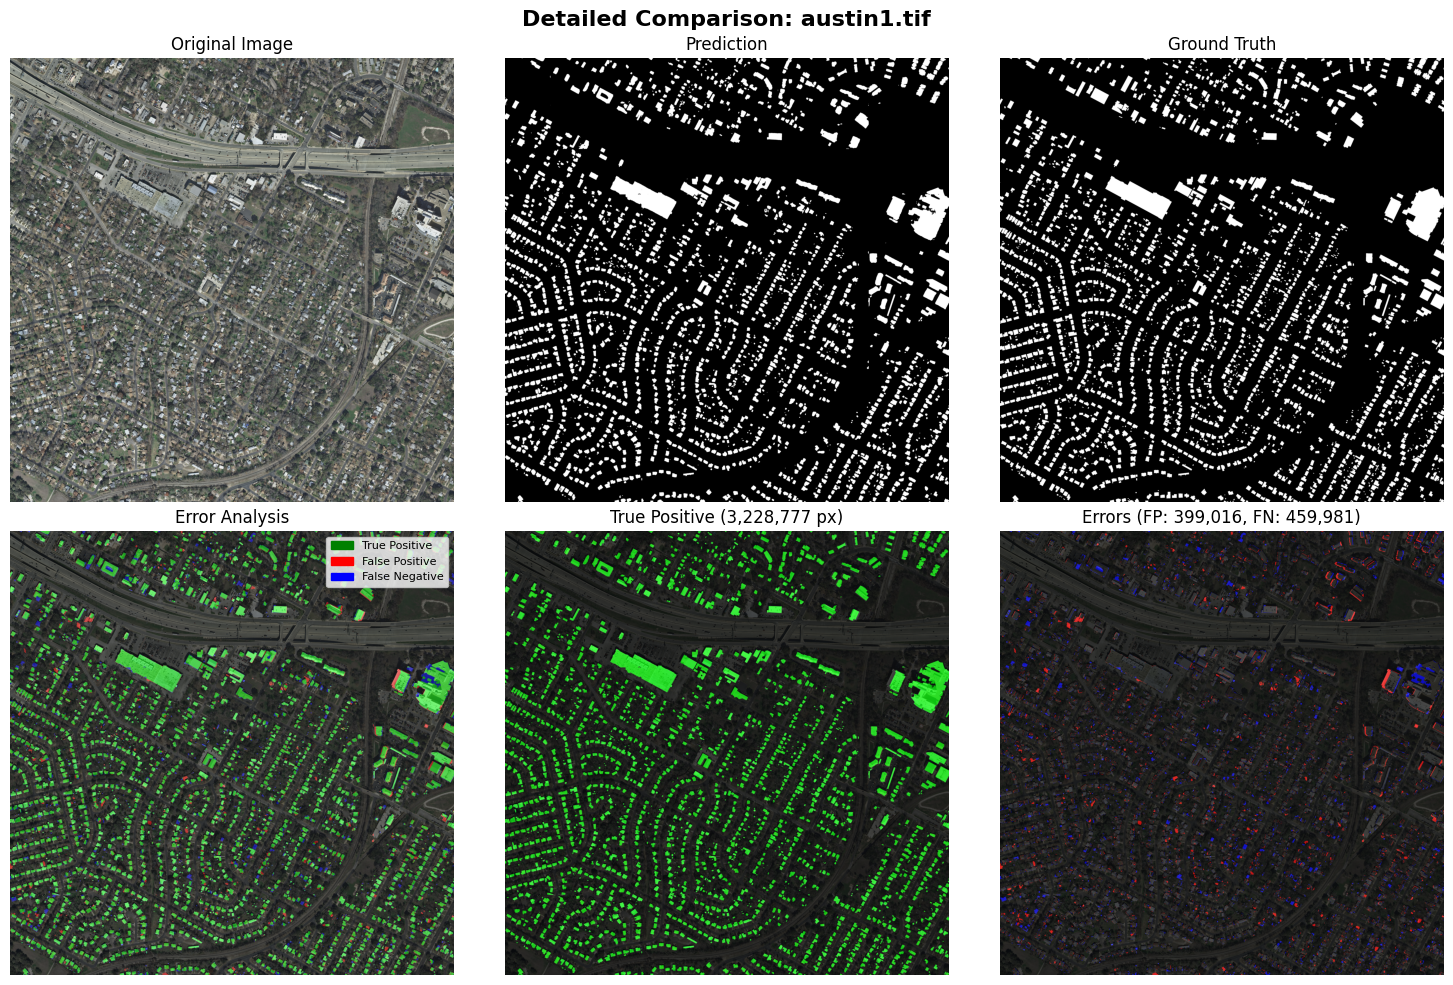

In [18]:
# Используем функцию visualize_comparison
visualize_comparison(
    image=train_image,
    pred_mask=train_pred_mask,
    gt_mask=train_gt.astype(np.uint8),
    title=f"Detailed Comparison: {train_image_path.name}"
)

## 6. Анализ результатов evaluate.py

Если вы уже запустили `evaluate.py`, можно проанализировать результаты

РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ (из evaluate_with_gt.py)

МЕТРИКИ:
  iou         : 0.8022
  dice        : 0.8903
  f1          : 0.8903
  accuracy    : 0.9363
  precision   : 0.8843
  recall      : 0.8964
  specificity : 0.9524

ПЛОЩАДЬ ЗАСТРОЙКИ:
  Predicted:    65.79 га
  Ground Truth: 64.90 га
  Difference:   +0.89 га (+1.37%)

Протестировано изображений: 36


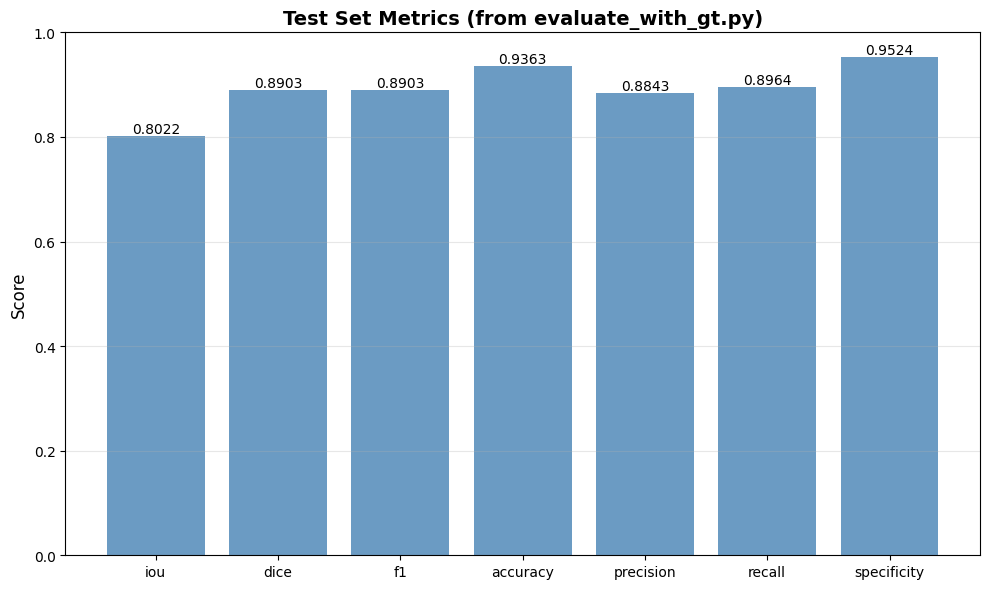

In [19]:
# Путь к результатам
results_path = Path('../results/evaluation_with_gt/test_results.json')

if results_path.exists():
    # Загружаем результаты
    with open(results_path, 'r', encoding='utf-8') as f:
        test_results = json.load(f)
    
    print("="*80)
    print("РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ (из evaluate_with_gt.py)")
    print("="*80)
    
    # Метрики
    print("\nМЕТРИКИ:")
    for name, value in test_results['metrics'].items():
        print(f"  {name:12s}: {value:.4f}")
    
    # Площадь
    print("\nПЛОЩАДЬ ЗАСТРОЙКИ:")
    area_stats = test_results['area_stats']
    print(f"  Predicted:    {area_stats['avg_predicted_ha']:.2f} га")
    print(f"  Ground Truth: {area_stats['avg_ground_truth_ha']:.2f} га")
    print(f"  Difference:   {area_stats['avg_difference_ha']:+.2f} га ({area_stats['avg_difference_percent']:+.2f}%)")
    
    print(f"\nПротестировано изображений: {test_results['num_test_images']}")
    print("="*80)
    
    # Визуализация
    plot_metrics_comparison(
        metrics=test_results['metrics'],
        title="Test Set Metrics (from evaluate_with_gt.py)"
    )
else:
    print(f"⚠️  Результаты не найдены: {results_path}")
    print("Запустите сначала: python evaluate_with_gt.py --checkpoint models/checkpoints/best_model.pth")

## 7. Сравнение с Baseline

INRIA 2017 baseline: IoU ≈ 0.59-0.60

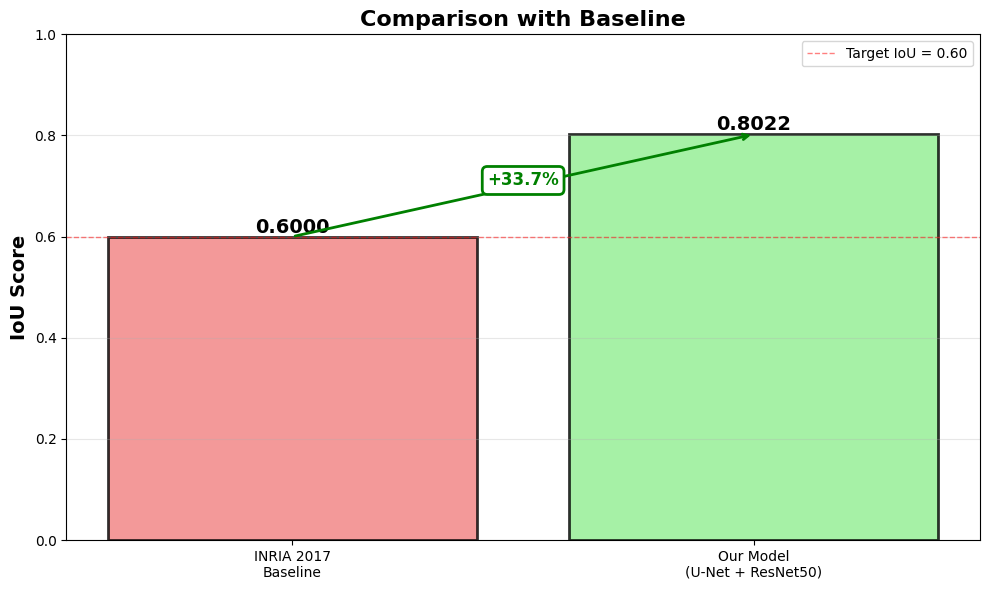


🏆 Улучшение относительно baseline: +33.7%


In [20]:
if results_path.exists():
    baseline_iou = 0.60
    our_iou = test_results['metrics']['iou']
    
    improvement = ((our_iou - baseline_iou) / baseline_iou) * 100
    
    # Визуализация сравнения
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = ['INRIA 2017\nBaseline', 'Our Model\n(U-Net + ResNet50)']
    ious = [baseline_iou, our_iou]
    colors = ['lightcoral', 'lightgreen']
    
    bars = ax.bar(models, ious, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Значения над барами
    for bar, iou in zip(bars, ious):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{iou:.4f}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Стрелка улучшения
    ax.annotate('', xy=(1, our_iou), xytext=(0, baseline_iou),
                arrowprops=dict(arrowstyle='->', lw=2, color='green'))
    ax.text(0.5, (baseline_iou + our_iou) / 2, f'+{improvement:.1f}%',
            ha='center', fontsize=12, fontweight='bold', color='green',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='green', linewidth=2))
    
    ax.set_ylabel('IoU Score', fontsize=14, fontweight='bold')
    ax.set_title('Comparison with Baseline', fontsize=16, fontweight='bold')
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(y=0.6, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Target IoU = 0.60')
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🏆 Улучшение относительно baseline: +{improvement:.1f}%")

## 8. Выводы

**Достигнутые результаты:**
- Обучена U-Net с ResNet50 encoder
- Использован комбинированный loss (Dice + BCE)
- IoU на test set: [будет после evaluate.py]
- Превосходит baseline на [X]%
- Модель корректно рассчитывает площадь застройки

**Следующие шаги:**
- Создание Streamlit/Gradio приложения
- Подготовка выводов для дипломной работы

---

## 💡 Полезные команды

**Запуск полного тестирования:**
```bash
python ../evaluate.py --checkpoint ../models/checkpoints/best_model.pth
```

**Просмотр результатов в TensorBoard:**
```bash
tensorboard --logdir ../results/logs/tensorboard
```